In [15]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from src.vae_model import vae_model
from src.mapper_model import mapper_model
from src.util import plot_mesh_permarray

from pyeit import mesh


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
n_el = 16  # nb of electrodes
mesh_obj = mesh.create(n_el, h0=0.05)


In [3]:
def load_all_data():
    voltage_dict = {} 
    gamma_dict = {} 
    data_dirs = sorted(glob("data*/"))  

    for i, directory in enumerate(data_dirs):
        file_list = sorted(glob(f"{directory}*.npz"))  
        voltage_list = []
        gamma_list = []

        for file in file_list:
            tmp = np.load(file, allow_pickle=True)  
            voltage_list.append(tmp["v"])  
            gamma_list.append(tmp["gamma"])  

        voltage_array = np.array(voltage_list) / 150
        voltage_array = np.expand_dims(voltage_array, axis=2)
        gamma_array = np.array(gamma_list) / 150          #WARUM Normalisierung?
        gamma_array = np.expand_dims(gamma_array, axis=2)
        
        # Speichere das Array im Dictionary
        voltage_dict[f"voltage{i}" if i > 0 else "voltage"] = voltage_array
        gamma_dict[f"gamma{i}" if i > 0 else "gamma"] = gamma_array
    
    return voltage_dict, gamma_dict

# Daten laden
voltage_dict, gamma_dict = load_all_data()

# Zugriff auf die Daten
voltage4 = voltage_dict["voltage4"]
gamma4 = gamma_dict["gamma4"]



In [4]:
#EIT = voltage4.reshape(-1, 32, 32, 1)
#perm_array = perm_array.reshape(-1, 2840, 1)

(1875, 32, 32, 1)

In [5]:
gamma4.shape

(10000, 2821, 1)

In [6]:
mapper = mapper_model()
mapper.summary()

mapper.compile(Adam(), loss="mse")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,736 (100.53 KB)

 Trainable params: 25,736 (100.53 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
vae = vae_model()  
vae.build(input_shape=(None, *gamma4.shape[1:])) 
vae.load_weights("weights/vae.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


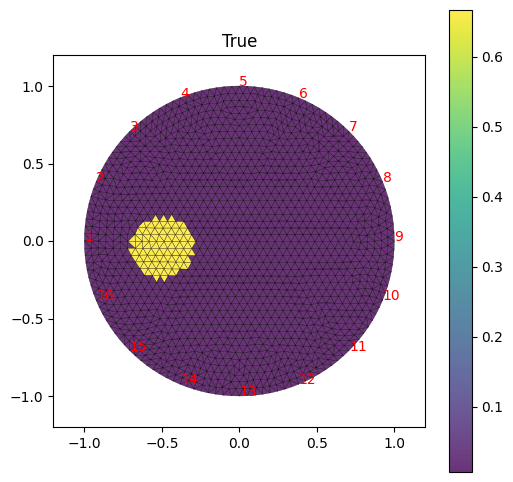

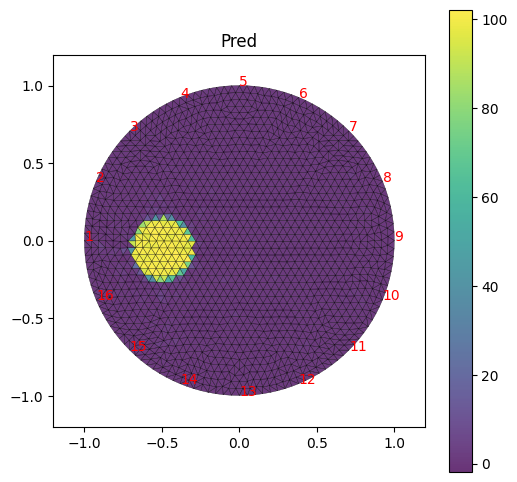

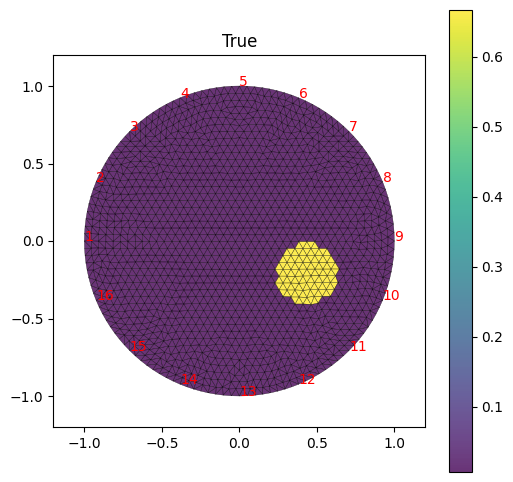

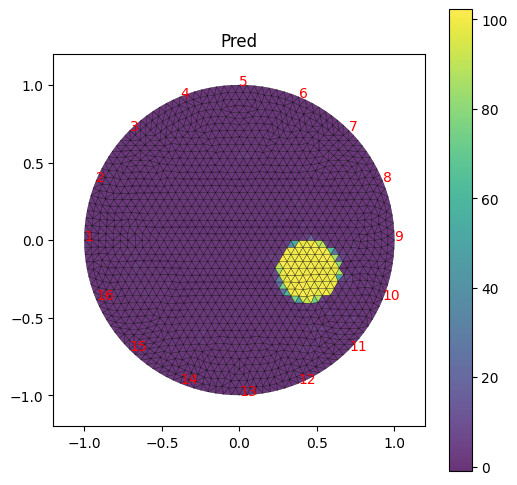

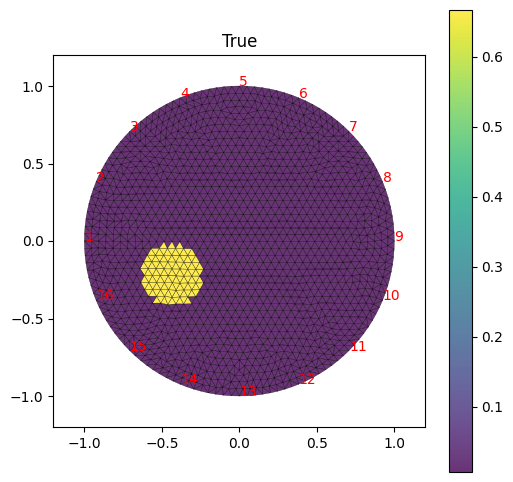

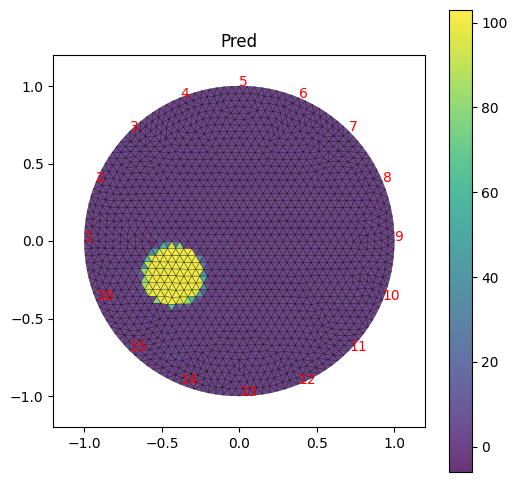

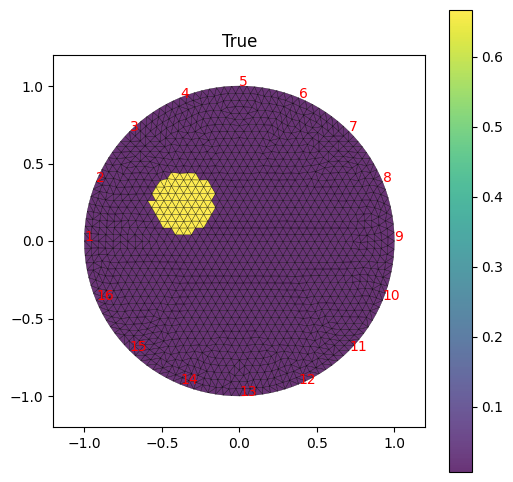

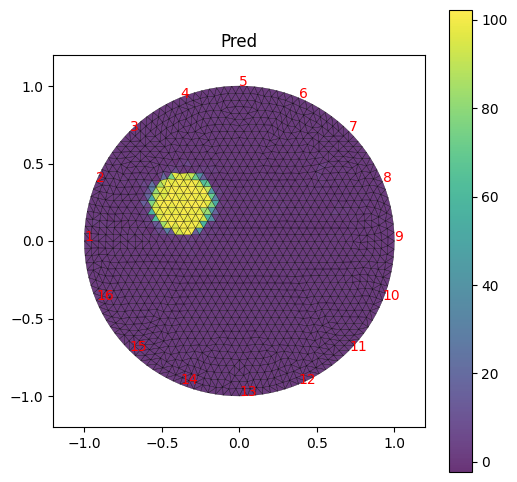

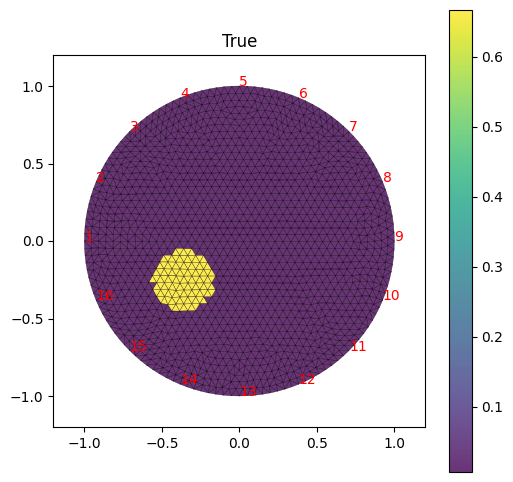

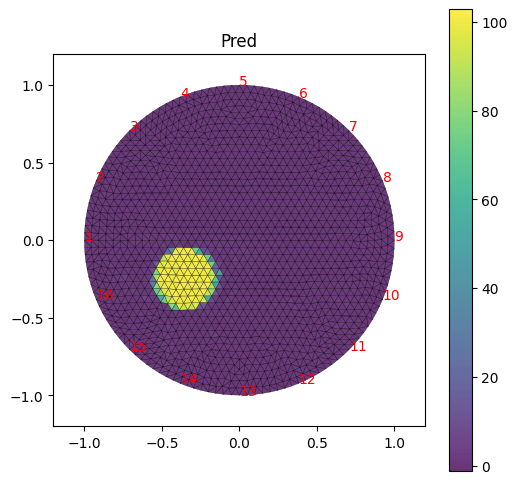

In [8]:
#gamma_train, gamma_test = train_test_split(gamma4, test_size=0.2, random_state=42)

z_mean, z_log_var, z = vae.encoder.predict(gamma4)
#gamma_hat = vae.decoder.predict(z) * 150
#for idx in np.random.randint(0, high=gamma4.shape[0], size=5):
    #plot_mesh_permarray(mesh_obj, gamma4[idx,:,0], title = "True")
    #plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")

In [9]:
#print(voltage4)

[[[[-0.00212038]
   [-0.00212147]
   [ 0.00121611]
   ...
   [ 0.00041712]
   [ 0.00030969]
   [ 0.00026373]]

  [[ 0.00026375]
   [ 0.00030972]
   [ 0.00041735]
   ...
   [ 0.00041117]
   [ 0.00063659]
   [ 0.00121844]]

  [[-0.00211861]
   [-0.00211946]
   [ 0.00122109]
   ...
   [ 0.00063772]
   [ 0.00041245]
   [ 0.00030495]]

  ...

  [[ 0.00025988]
   [ 0.00025955]
   [ 0.00030501]
   ...
   [ 0.00041538]
   [ 0.00064104]
   [ 0.00122158]]

  [[-0.00212042]
   [-0.0021215 ]
   [ 0.00121611]
   ...
   [ 0.00041713]
   [ 0.00030971]
   [ 0.00026375]]

  [[ 0.00026377]
   [ 0.00030974]
   [ 0.00041736]
   ...
   [ 0.00041119]
   [ 0.0006366 ]
   [ 0.00121844]]]


 [[[-0.00211862]
   [-0.00211948]
   [ 0.00122106]
   ...
   [ 0.00063774]
   [ 0.00041252]
   [ 0.00030503]]

  [[ 0.00030601]
   [ 0.00026092]
   [ 0.00026195]
   ...
   [ 0.00030946]
   [ 0.00041636]
   [ 0.00064005]]

  [[ 0.00121781]
   [-0.00212296]
   [-0.00212313]
   ...
   [ 0.00064253]
   [ 0.00041593]
   [ 0.0003

In [10]:
(v_train, v_test, gamma_train, gamma_test, z_train, z_test) = train_test_split(voltage4,gamma4,z,test_size=0.1,shuffle=False,random_state=42)
v_train.shape, z.shape

ValueError: Found input variables with inconsistent numbers of samples: [1875, 10000, 10000]

In [ ]:
history_mapper = mapper.fit(
    v_train,  
    z_train,  
    epochs=50, 
    batch_size=8, 
    validation_data=(v_test, z_test)  
)

In [ ]:
plt.plot(history_mapper.history['loss'], label='Training Loss')  # Training Loss
plt.plot(history_mapper.history['val_loss'], label='Validation Loss')  # Validation Loss
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def reconstruct_from_voltage(voltage_input):
    z_hat = mapper.predict(voltage_input)
    gamma_hat = vae.decoder.predict(z_hat)
    return gamma_hat, z_hat

gamma_hat, z_hat = reconstruct_from_voltage(v_test)

for idx in np.random.randint(0, high=gamma_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, gamma_test[idx, :, 0], title="True")
    
    plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")
